<a href="https://colab.research.google.com/github/ChaituThombare/Organic-VS-Recycle-Classification-Using-Transfer-Learning/blob/main/Organic_VS_Recycle_Classification(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y tensorflow jax jaxlib tensorflow-text tf-keras optax flax orbax-checkpoint
!pip install tensorflow==2.16.1
!pip install numpy==1.26.4
!pip install scikit-learn==1.4.1
!pip install matplotlib==3.8.2
!pip install jax==0.4.27 jaxlib==0.4.27


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: tensorflow-text 2.18.1
Uninstalling tensorflow-text-2.18.1:
  Successfully uninstalled tensorflow-text-2.18.1
Found existing installation: tf_keras 2.18.0
Uninstalling tf_keras-2.18.0:
  Successfully uninstalled tf_keras-2.18.0
Found existing installation: optax 0.2.4
Uninstalling optax-0.2.4:
  Successfully uninstalled optax-0.2.4
Found existing installation: flax 0.10.4
Uninstalling flax-0.10.4:
  Successfully uninstalled flax-0.10.4
Found existing installation: orbax-checkpoint 0.11.9
Uninstalling orbax-checkpoint-0.11.9:
  Successfully uninstalled orbax-checkpoint-0.11.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires flax>=0.2.0, which is not installed.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, which is not installed.


In [ ]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib  # Import the main matplotlib module
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
import warnings
import sklearn # Import the main sklearn module

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set TensorFlow log level to avoid unnecessary logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Print package versions (for verification)
print(f"✅ TensorFlow Version: {tf.__version__}")
print(f"✅ Numpy Version: {np.__version__}")
print(f"✅ Matplotlib Version: {matplotlib.__version__}")  # Access version from 'matplotlib'
print(f"✅ Scikit-learn Version: {sklearn.__version__}") # Access version from 'sklearn'

✅ TensorFlow Version: 2.16.1
✅ Numpy Version: 1.26.4
✅ Matplotlib Version: 3.8.2
✅ Scikit-learn Version: 1.6.1


In [ ]:
import requests
import zipfile
import os  # ✅ Import missing os module
from tqdm import tqdm

# URL of the dataset
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"
extract_path = "extracted_data"

# Step 1: Download the file
print("Downloading file...")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

print("Download complete!")

# Step 2: Extract the file with progress bar
def extract_file_with_progress(file_name, extract_to):
    print("Extracting file with progress...")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist()
        os.makedirs(extract_to, exist_ok=True)

        with tqdm(total=len(members), unit='file', desc="Extracting") as progress_bar:
            for member in members:
                zip_ref.extract(member, extract_to)
                progress_bar.update(1)

    print(f"Finished extracting files to: {extract_to}")

extract_file_with_progress(file_name, extract_path)

# Step 3: Remove the ZIP file after extraction
os.remove(file_name)
print(f"Removed ZIP file: {file_name}")


Download complete!
Extracting file with progress...


Extracting: 100%|██████████| 1207/1207 [00:00<00:00, 4577.32file/s]

Finished extracting files to: extracted_data
Removed ZIP file: o-vs-r-split-reduced-1200.zip


In [ ]:
# configuration options
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path_train = '/content/extracted_data/o-vs-r-split/train'
path_test = '/content/extracted_data/o-vs-r-split/test'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

In [ ]:
# Create ImageDataGenerators for training and validation and testing
# teaching all data to help learning
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# small quiz like , to check learning
val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

# final test
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [ ]:
# create training data
train_generator = train_datagen.flow_from_directory(
    directory = path_train,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [ ]:
path_train_o = '/content/extracted_data/o-vs-r-split/train/O'
path_train_r = '/content/extracted_data/o-vs-r-split/train/R'
path_test_o = '/content/extracted_data/o-vs-r-split/test/O'
path_test_r = '/content/extracted_data/o-vs-r-split/test/R'
len(os.listdir(path_train_o)), len(os.listdir(path_train_r)), len(os.listdir(path_test_o)), len(os.listdir(path_test_r))

(500, 500, 100, 100)

In [ ]:
# create validation data
val_generator = val_datagen.flow_from_directory(
    directory = path_train,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


In [ ]:
# create testing data
test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 200 images belonging to 2 classes.


In [ ]:
# Task 3: print the length of the `train_generator`
# this tell no. of batches of images i.e = 800 / 32 = 25
print(len(train_generator))

25


Labels: [0, 0, 0, 0, 0]


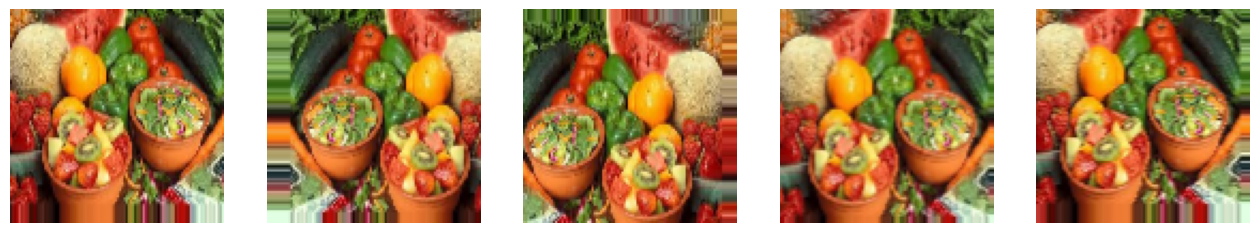

In [ ]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

IMG_DIM = (100, 100)

# Get first 20 images from 'O' class
train_files = glob.glob('/content/extracted_data/o-vs-r-split/train/O/*')[:20]

# Convert images to numpy arrays
train_imgs = [tf.keras.preprocessing.image.img_to_array(
    tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)
) for img in train_files]

train_imgs = np.array(train_imgs)  # Convert list to numpy array

# Extract labels (folder name 'O' in this case)
train_labels = [Path(fn).parent.name for fn in train_files]

# Convert labels to numeric (0 - organic, 1 - recycle)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)

# Select first image for augmentation visualization
img_id = 0
O_generator = train_datagen.flow(
    train_imgs[img_id:img_id+1],  # Single image
    train_labels[img_id:img_id+1],  # Corresponding label (numeric)
    batch_size=1
)

# Generate 5 augmented versions of the image
O = [next(O_generator) for i in range(5)]

# Plot the images
fig, ax = plt.subplots(1, 5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])  # Print labels

# Display images
for i in range(5):
    ax[i].imshow(O[i][0][0])  # Extract image from batch
    ax[i].axis('off')

plt.show()


In [ ]:
# load pre-trained VGG16 model
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [ ]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

In [ ]:
# freeze  the basemodel
for layer in basemodel.layers:
  layer.trainable = False;

In [ ]:
# create new model on top
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# print model's summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_2 (Functional)            │ (None, 8192)                │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# compile the model
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# early stopping
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

checkpoint_path = 'O_R_tlearn_vgg16.keras'

# Define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))  # Fixed here
        print('lr:', exp_decay(epoch))  # Fixed here

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k * epoch)
    return lrate

# Learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor='val_loss',
                    patience=4,
                    mode='min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks


In [ ]:
# fit and train the model
extract_feat_model = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=10,
    callbacks=callbacks_list_,
    validation_data=val_generator,
    validation_steps=int(np.ceil(val_generator.samples / batch_size)),
    verbose=1
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9227 - loss: 0.1988lr: 0.0001
25/25 ━━━━━━━━━━━━━━━━━━━━ 264s 11s/step - accuracy: 0.9223 - loss: 0.1994 - val_accuracy: 0.8900 - val_loss: 0.2132 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9427 - loss: 0.1776lr: 9.048374180359596e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 320s 11s/step - accuracy: 0.9424 - loss: 0.1778 - val_accuracy: 0.8900 - val_loss: 0.2216 - learning_rate: 9.0484e-05
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9277 - loss: 0.1888lr: 8.187307530779819e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 321s 11s/step - accuracy: 0.9280 - loss: 0.1881 - val_accuracy: 0.9000 - val_loss: 0.2157 - learning_rate: 8.1873e-05
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9392 - loss: 0.1516lr: 7.408182206817179e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step - accuracy: 0.9394 - loss: 0.1514 - val_accuracy: 0.9200 - val_loss: 0.2045 - learning_rate: 7.4082e-05
Epo

In [ ]:
print(type(extract_feat_model))  # Should be <class 'keras.callbacks.History'>

<class 'keras.src.callbacks.history.History'>


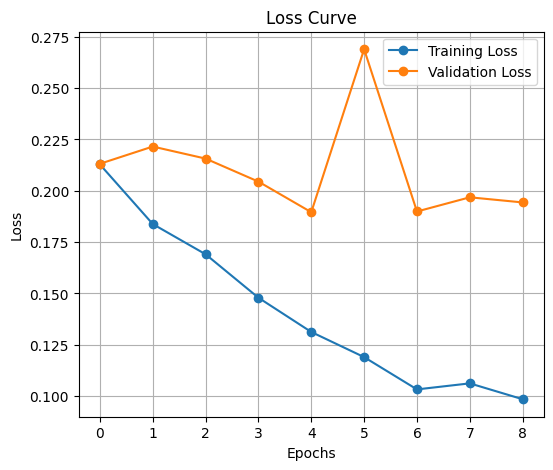

In [ ]:
import matplotlib.pyplot as plt

# Ensure we have the correct history object
history = extract_feat_model

# Plot loss curve
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


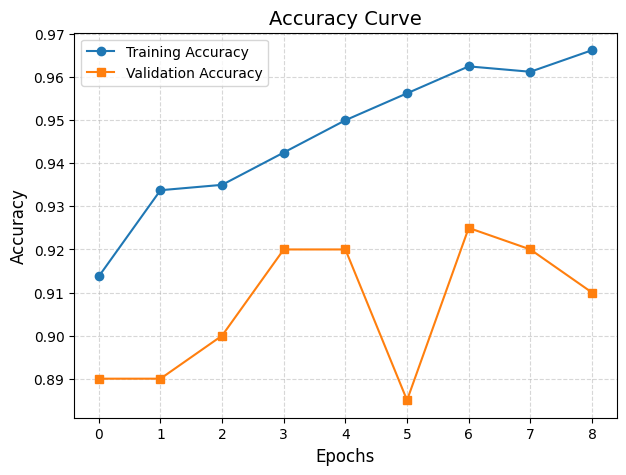

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
history = extract_feat_model  # Ensure this contains `model.fit(...)` output

# Plot Accuracy Curve
plt.figure(figsize=(7, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Accuracy Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Save the plot
plt.savefig('plot_accuracy_curve.png', dpi=300)  # High resolution
plt.show()


In [ ]:
# unfreeze a layer and rebuild a new model on top
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Define input shape
input_shape = (150, 150, 3)

# Load pre-trained VGG16 model (without top layers)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

# Flatten the output
output = tf.keras.layers.Flatten()(vgg.output)
basemodel = Model(inputs=vgg.input, outputs=output)

# Freeze all layers initially
for layer in basemodel.layers:
    layer.trainable = False

# Unfreeze 'block5_conv3' for fine-tuning
set_trainable = False
for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Print trainable status of layers
for layer in basemodel.layers:
    print(f"{layer.name}: {'Trainable' if layer.trainable else 'Frozen'}")


input_layer_5: Frozen
block1_conv1: Frozen
block1_conv2: Frozen
block1_pool: Frozen
block2_conv1: Frozen
block2_conv2: Frozen
block2_pool: Frozen
block3_conv1: Frozen
block3_conv2: Frozen
block3_conv3: Frozen
block3_pool: Frozen
block4_conv1: Frozen
block4_conv2: Frozen
block4_conv3: Frozen
block4_pool: Frozen
block5_conv1: Frozen
block5_conv2: Frozen
block5_conv3: Trainable
block5_pool: Trainable
flatten_5: Trainable


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define model architecture
model = Sequential([
    basemodel,  # Pre-trained VGG16 feature extractor
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

checkpoint_path = 'O_R_tlearn_fine_tune_vgg16.keras'

# Learning schedule callback (assuming LossHistory_ and exp_decay are defined)
lrate_ = LearningRateScheduler(exp_decay)
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, mode='min', min_delta=0.01),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [LossHistory_(), lrate_] + keras_callbacks  # Combined callbacks

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

# Ensure batch_size is defined
batch_size = 32  # Set batch size accordingly

# Train model
fine_tune_model = model.fit(
    train_generator,
    steps_per_epoch=max(5, train_generator.samples // batch_size),  # Ensures at least 5 steps per epoch
    epochs=10,
    callbacks=callbacks_list_,
    validation_data=val_generator,
    validation_steps=max(1, len(val_generator) // batch_size),  # Avoids division by zero
    verbose=1
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6515 - loss: 0.6098lr: 0.0001
25/25 ━━━━━━━━━━━━━━━━━━━━ 233s 9s/step - accuracy: 0.6543 - loss: 0.6065 - val_accuracy: 0.8125 - val_loss: 0.3635 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8199 - loss: 0.3988lr: 9.048374180359596e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 261s 11s/step - accuracy: 0.8207 - loss: 0.3976 - val_accuracy: 0.8750 - val_loss: 0.3132 - learning_rate: 9.0484e-05
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8738 - loss: 0.3078lr: 8.187307530779819e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 261s 11s/step - accuracy: 0.8737 - loss: 0.3077 - val_accuracy: 0.9688 - val_loss: 0.1588 - learning_rate: 8.1873e-05
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9103 - loss: 0.2109lr: 7.408182206817179e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 226s 9s/step - accuracy: 0.9101 - loss: 0.2113 - val_accuracy: 0.7812 - val_loss: 0.3470 - learning_rate: 7.4082e-05
Epoch

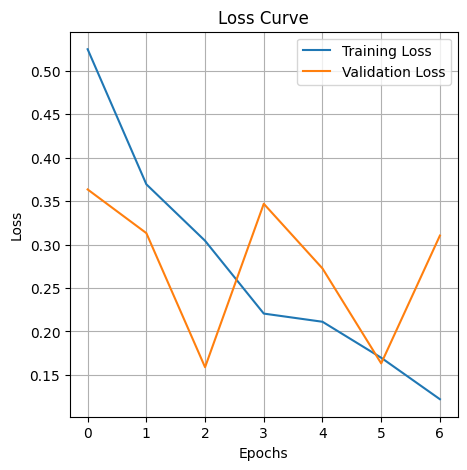

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
history = fine_tune_model.history # <-- Correct way to access history data

# Plot loss curves
plt.figure(figsize=(5, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


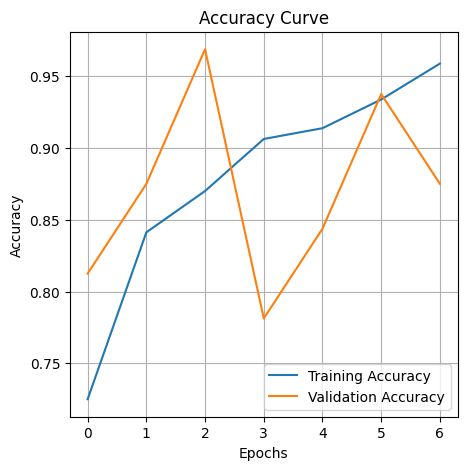

In [ ]:
# Task 8: Plot accuracy curves for training and validation sets  (fine tune model)
history = fine_tune_model.history
# Plot accuracy curves
plt.figure(figsize=(5, 5))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# test on testing data
import tensorflow as tf
import numpy as np
import glob
from pathlib import Path
from sklearn import metrics

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('/content/extracted_data/o-vs-r-split/test/O/*')
test_files_R = glob.glob('/content/extracted_data/o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(
    tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)

# Extract labels
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize images
test_imgs_scaled = test_imgs.astype('float32') / 255.0

# Convert labels to numeric
class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0).flatten()
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0).flatten()

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.81      0.88      0.85        50
           R       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.82      0.82      0.82        50
           R       0.82      0.82      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



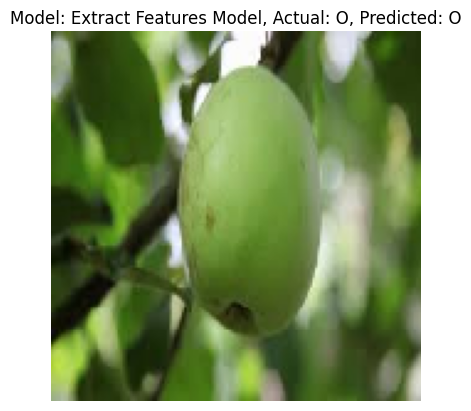

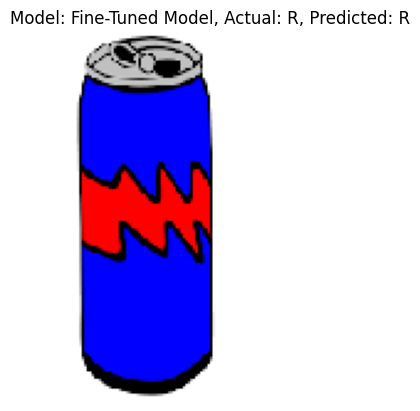

In [ ]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )
index_to_plot = 66
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_fine_tune_model[index_to_plot],
    )

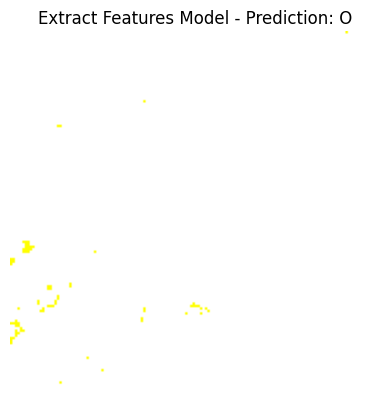

In [ ]:
# Task 9: Plot a test image using Extract Features Model (index_to_plot = 1)
import matplotlib.pyplot as plt
# Function to plot the image with a title
def plot_image_with_title(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

index_to_plot = 0
test_image = test_imgs[index_to_plot]
predicted_label = predictions_extract_feat_model[index_to_plot]
plot_image_with_title(test_image, f"Extract Features Model - Prediction: {predicted_label}")

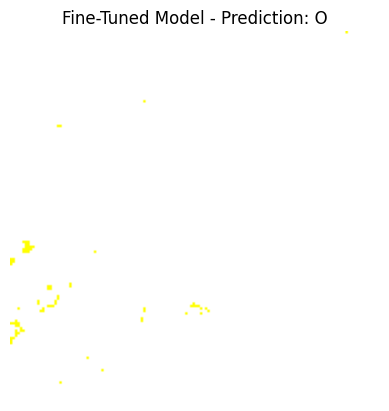

In [ ]:
# Task 10: Plot a test image using Fine-Tuned Model (index_to_plot = 1)
import matplotlib.pyplot as plt
# Function to plot the image with a title
def plot_image_with_title(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

index_to_plot = 0
test_image = test_imgs[index_to_plot]  # Assuming test_images is your dataset
predicted_label = predictions_fine_tune_model[index_to_plot]  # Fine-tuned model prediction
plot_image_with_title(test_image, f"Fine-Tuned Model - Prediction: {predicted_label}")

In [1]:
extract_feat_model.save('extract_features_vgg16.keras')
fine_tune_model.save('fine_tuned_vgg16.keras')


NameError: name 'extract_feat_model' is not defined